#### Environment

In [ ]:
required_training = True
%matplotlib inline
import matplotlib.pyplot as plt  # one of the best graphics library for python
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
import torchvision

#### Model

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, x):
        x = self.network(x)
        return x

In [ ]:
my_model = MyModel()
print(my_model)

MyModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=

#### Prepare data

In [ ]:
def get_mean_std_train_data(data_root):
    
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.CIFAR10(root=data_root, train=True, download=True, transform=train_transform)
    
    # return mean (numpy.ndarray) and std (numpy.ndarray)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    imgs = [item[0] for item in train_set]
    imgs = torch.stack(imgs,dim=0).numpy()
    mean_r = imgs[:,0,:,:].mean()
    mean_g = imgs[:,1,:,:].mean()
    mean_b = imgs[:,2,:,:].mean()
    std_r = imgs[:,0,:,:].std()
    std_g = imgs[:,1,:,:].std()
    std_b = imgs[:,2,:,:].std()
    mean[0],mean[1],mean[2] = mean_r, mean_g, mean_b
    std[0],std[1],std[2] = std_r, std_g, std_b

    return mean, std



In [ ]:
def get_data(batch_size, data_root, num_workers=1):
    
    
    try:
        mean, std = get_mean_std_train_data(data_root)
        assert len(mean) == len(std) == 3
    except:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        
    
    train_test_transforms = transforms.Compose([
        # this re-scale image tensor values between 0-1. image_tensor /= 255
        transforms.ToTensor(),
        # subtract mean and divide by variance.
        transforms.Normalize(mean, std)
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root=data_root, train=True, download=False, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root=data_root, train=False, download=False, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

#### Configuration and setup

In [ ]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42 
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 16  
    epochs_count: int = 10 
    learning_rate: float = 0.01  
        
    log_interval: int = 100  
    test_interval: int = 1  
    # data_root: str = "../resource/lib/publicdata/images"  # folder to save data
    data_root: str = "root/content/drive/MyDrive/Colab Notebooks/" 
    num_workers: int = 10  
    device: str = 'cuda'  

def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

#### Train & validate

In [ ]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

In [ ]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    return test_loss, accuracy/100.0

#### Save model

In [ ]:
def save_model(model, device, model_dir='models', model_file_name='cifar10_cnn_model.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    if int(torch.__version__.split('.')[1]) >= 6:
        torch.save(model.state_dict(), model_path, _use_new_zipfile_serialization=False)
    
    else:
        torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

#### Main processor

In [ ]:
def main(system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)

    
    batch_size_to_set = training_configuration.batch_size
    num_workers_to_set = training_configuration.num_workers
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        num_workers_to_set = 2

    # data loader
    train_loader, test_loader = get_data(
        batch_size=training_configuration.batch_size,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        num_workers=num_workers_to_set
    )

    # initiate model
    model = MyModel()
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)
    best_accuracy = torch.tensor(0)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
            
            if current_accuracy > best_accuracy:
                best_accuracy = current_accuracy
                print('Accuracy improved, saving the model.\n')
                save_model(model, device)
            
                
    print("Total time: {:.2f}, Best Loss: {:.3f}, Best Accuracy: {:.3f}".format(time.time() - t_begin, best_loss, 
                                                                                best_accuracy))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [ ]:
if required_training:
    model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main()

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch: 0 [1600/50000] Loss: 1.981932 Acc: 0.1250
Train Epoch: 0 [3200/50000] Loss: 1.672257 Acc: 0.3750
Train Epoch: 0 [4800/50000] Loss: 1.360800 Acc: 0.3750
Train Epoch: 0 [6400/50000] Loss: 1.279480 Acc: 0.5625
Train Epoch: 0 [8000/50000] Loss: 1.225201 Acc: 0.3750
Train Epoch: 0 [9600/50000] Loss: 1.417780 Acc: 0.5000
Train Epoch: 0 [11200/50000] Loss: 1.533286 Acc: 0.6250
Train Epoch: 0 [12800/50000] Loss: 1.161696 Acc: 0.6250
Train Epoch: 0 [14400/50000] Loss: 1.217224 Acc: 0.5625
Train Epoch: 0 [16000/50000] Loss: 1.653703 Acc: 0.2500
Train Epoch: 0 [17600/50000] Loss: 0.932185 Acc: 0.6875
Train Epoch: 0 [19200/50000] Loss: 1.339356 Acc: 0.5625
Train Epoch: 0 [20800/50000] Loss: 0.738814 Acc: 0.6875
Train Epoch: 0 [22400/50000] Loss: 0.943272 Acc: 0.6875
Train Epoch: 0 [24000/50000] Loss: 0.819924 Acc: 0.6250
Train Epoch: 0 [25600/50000] Loss: 0.856777 Acc: 0.6875
Train Epoch: 0 [27200/50000] Loss: 1.237738 Acc: 0.5625
Train Epoch: 0 [28800/50000] Loss: 1.172905 Acc: 0.625

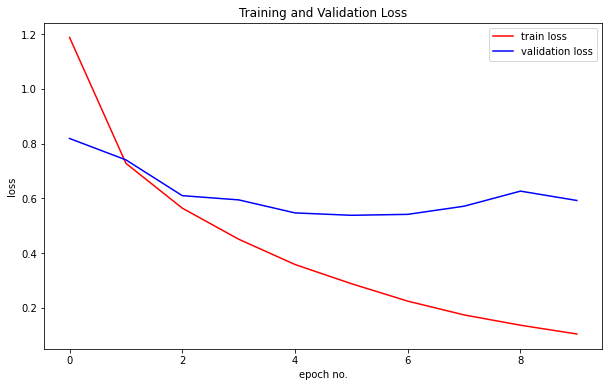

In [ ]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_loss, color='r', label="train loss")
plt.plot(x, epoch_test_loss, color='b', label="validation loss")
plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

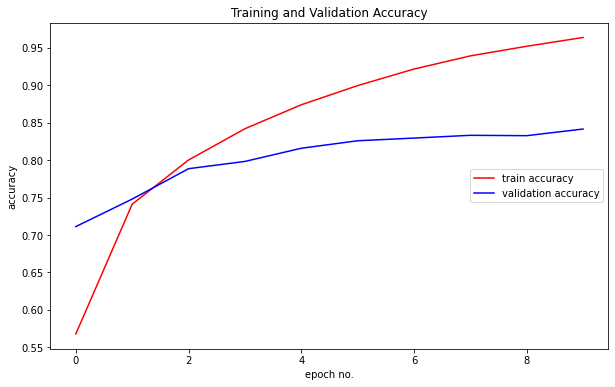

In [ ]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_acc, color='r', label="train accuracy")
plt.plot(x, epoch_test_acc, color='b', label="validation accuracy")
plt.xlabel('epoch no.')
plt.ylabel('accuracy')
plt.legend(loc='center right')
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
# initialize the model
cnn_model = MyModel()

models = 'models'

model_file_name = 'cifar10_cnn_model.pt'

model_path = os.path.join(models, model_file_name)

# loading the model and getting model parameters by using load_state_dict
cnn_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
def prediction(model, train_config, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(train_config.device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(train_config.device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

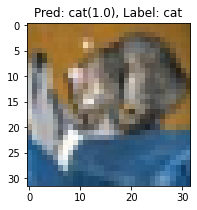

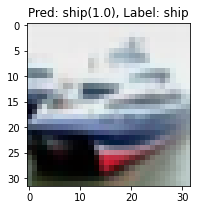

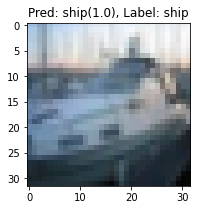

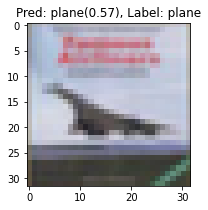

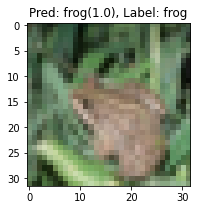

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch_size = 5
train_config = TrainingConfiguration()

if torch.cuda.is_available():
    train_config.device = "cuda"
else:
    train_config.device = "cpu"
    
    

# load test data without image transformation
test = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=train_config.data_root, train=False, download=False, 
                   transform=transforms.functional.to_tensor),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

try:
    mean, std = get_mean_std_train_data(data_root)
    assert len(mean) == len(std) == 3
except:
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)

# load testdata with image transformation
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

test_trans = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=train_config.data_root, train=False, download=False, transform=image_transforms),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

for data, _ in test_trans:
    # pass the loaded model
    pred, prob = prediction(cnn_model, train_config, data)
    break
    

plt.rcParams["figure.figsize"] = (3, 3)
for images, label in test:
    for i, img in enumerate(images):
        img = transforms.functional.to_pil_image(img)
        plt.imshow(img)
        plt.gca().set_title('Pred: {0}({1:0.2}), Label: {2}'.format(classes[pred[i]], prob[i], classes[label[i]]))
        plt.show()
    break